In [1]:
# module import
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import pickle
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

In [2]:
# 경로 설정
root_path = "/content/drive/My Drive/멀티캠퍼스/[혁신성장] 인공지능 자연어처리 기반/[강의]/조성현 강사님"
data_path = f"{root_path}/dataset"

In [3]:
# 데이터 로드
with open(f"{data_path}/mnist.pickle", 'rb') as f:
    data = pickle.load(f)

In [4]:
# 데이터 확인
dir(data)

['DESCR', 'categories', 'data', 'details', 'feature_names', 'target', 'url']

# _1_. Sigmoid, BinaryCrossentropy

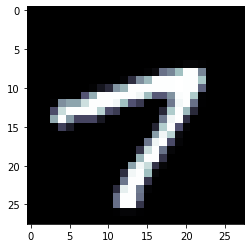

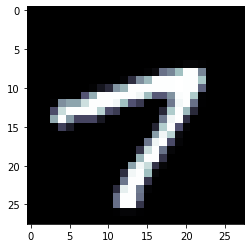

In [ ]:
# 입력 데이터 생성
X_train = mnist.data[:3000, :] / 255
X_test = mnist.data[3000:3100, :] / 255

plt.imshow(mnist.data[101].reshape(28, 28), cmap=plt.cm.bone)
plt.show()
plt.imshow(X_train[101].reshape(28, 28), cmap=plt.cm.bone)
plt.show()

노이즈 삽입 전: (3000, 784), 노이즈 삽입 후: (3000, 784)


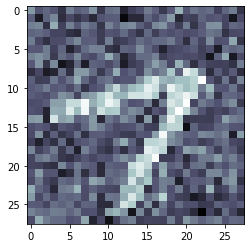

In [ ]:
# 노이즈 삽입
X_train_n = X_train + 0.3*np.random.normal(size=X_train.shape)
X_test_n = X_test + 0.3*np.random.normal(size=X_test.shape)
print(f"노이즈 삽입 전: {X_train.shape}, 노이즈 삽입 후: {X_train_n.shape}")

# 확인
plt.imshow(X_train_n[101].reshape(28, 28), cmap=plt.cm.bone)
plt.show()

In [ ]:
# clip
X_train_n_clipped = np.clip(X_train_n, 0., 1.)
X_test_n_clipped = np.clip(X_test_n, 0., 1.)

In [ ]:
# CNN에 주입하기 위해 차원 증가
print("훈련 데이터")
X_train = X_train.reshape(-1, 28, 28)
X_test = X_test.reshape(-1, 28, 28)
print(f"3차원 변환 후: {X_train.shape}")
print(f"3차원 변환 후: {X_test.shape}")
print("")
print("테스트 데이터")
X_train_n = X_train_n_clipped.reshape(-1, 28, 28)
X_test_n = X_test_n_clipped.reshape(-1, 28, 28)
print(f"3차원 변환 전: {X_train_n_clipped.shape}, 후: {X_train.shape}")
print(f"3차원 변환 전: {X_test_n_clipped.shape}, 후: {X_test.shape}")

훈련 데이터
3차원 변환 후: (3000, 28, 28)
3차원 변환 후: (100, 28, 28)

테스트 데이터
3차원 변환 전: (3000, 784), 후: (3000, 28, 28)
3차원 변환 전: (100, 784), 후: (100, 28, 28)


In [ ]:
# CNN 파라미터: 노이즈 데이터를 주입할 것이기 때문에 노이즈로!!
n_height = X_train_n.shape[1] # 28
n_width = X_train_n.shape[2]
n_channel = 1 # 흑백 이미지

In [ ]:
# 오토인코더 레이어 구성
x_Input = Input(batch_shape=(None, n_height, n_width, n_channel))

# 인코더
e_conv = Conv2D(filters=10, kernel_size=(3, 3), strides=1, padding='SAME', activation='relu')(x_Input) # same: 28*28
e_pool = MaxPooling2D(pool_size=(2,2), strides=1, padding='SAME')(e_conv) # same! 28 x 28

# 디코더
d_conv = Conv2DTranspose(filters=10, kernel_size=(3, 3), strides=1, padding='SAME', activation='relu')(e_pool) # 아마 same이니까 28*28
x_Output = Conv2D(filters=1, kernel_size=(3, 3), strides=1, padding='SAME', activation='sigmoid')(d_conv) # 0~1 사이 값으로 뽑아내야 하므로 sigmoid!

In [ ]:
# 모델 구성
model = Model(x_Input, x_Output)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.005)) # 이거 그냥 전에 sigmoid여서?
print("====== 모델 전체 구조 =====")
print(model.summary())

====== 모델 전체 구조 =====
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 28, 28, 10)        0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 10)        910       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 1)         91        
Total params: 1,101
Trainable params: 1,101
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# 4차원에 맞추기 위해 채널 축 추가
X_train_n = X_train_n[:, :, :, np.newaxis]

# 오토인코더 학습: X_train과 X_train_n을 맞춘다.
hist = model.fit(X_train_n, X_train, epochs=100, batch_size=300, shuffle=True)

Epoch 1/100
10/10 [==============================] - 5s 461ms/step - loss: 0.5708
Epoch 2/100
10/10 [==============================] - 4s 433ms/step - loss: 0.3807
Epoch 3/100
10/10 [==============================] - 4s 377ms/step - loss: 0.2645
Epoch 4/100
10/10 [==============================] - 4s 382ms/step - loss: 0.2133
Epoch 5/100
10/10 [==============================] - 4s 362ms/step - loss: 0.1796
Epoch 6/100
10/10 [==============================] - 4s 365ms/step - loss: 0.1572
Epoch 7/100
10/10 [==============================] - 4s 375ms/step - loss: 0.1414
Epoch 8/100
10/10 [==============================] - 4s 370ms/step - loss: 0.1155
Epoch 9/100
10/10 [==============================] - 4s 387ms/step - loss: 0.0965
Epoch 10/100
10/10 [==============================] - 4s 361ms/step - loss: 0.0908
Epoch 11/100
10/10 [==============================] - 4s 372ms/step - loss: 0.0875
Epoch 12/100
10/10 [==============================] - 4s 386ms/step - loss: 0.0862
Epoch 13/100


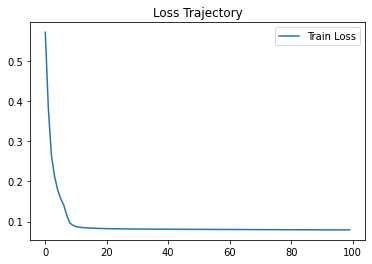

In [ ]:
# plot loss
plt.plot(hist.history['loss'], label='Train Loss')
plt.title('Loss Trajectory')
plt.legend()
plt.show()

In [ ]:
# 화면에 이미지 그림
def showImage(x):
    n = 0
    for k in range(2): # figure 2개에 10개 나눠 그림 그리기 위해 range(2)
        plt.figure(figsize=(8, 2))
        for i in range(5):
            ax = plt.subplot(1, 5, i+1)
            plt.imshow(x[n].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            n += 1
        plt.show()

잡음이 삽입된 테스트 데이터 10개


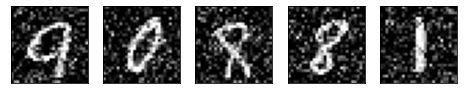

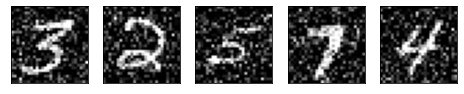

In [ ]:
# 노이즈가 추가된 데이터 10개
print("잡음이 삽입된 테스트 데이터 10개")
showImage(X_test_n)

In [ ]:
# 오토인코더 모델에 통과시켜서 잡음 제거
print(f"원래 테스트 데이터: {X_test_n.shape}")
X_test_n = X_test_n.reshape(-1, 28, 28)
X_test_n = X_test_n[:, :, :, np.newaxis] # 채널 축 추가
print(f"모델에 넣기 위해 차원을 변경한 데이터: {X_test_n.shape}")

원래 테스트 데이터: (100, 28, 28)
모델에 넣기 위해 차원을 변경한 데이터: (100, 28, 28, 1)


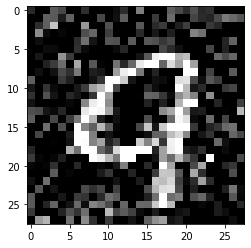

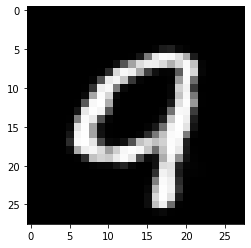

In [ ]:
X_test_detected = model.predict(X_test_n)
plt.imshow(X_test_n[0].reshape(28, 28))
plt.show()
plt.imshow(X_test_detected[0].reshape(28, 28))
plt.show()

잡음을 제거한 테스트 데이터 10개


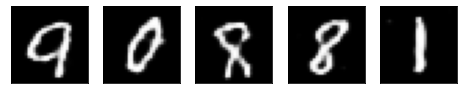

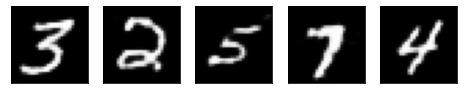

In [ ]:
# 잡음을 제거한 테스트 데이터 10개
print("잡음을 제거한 테스트 데이터 10개")
showImage(X_test_detected)

## 모델 shape 확인

In [ ]:
test = Model(x_Input, e_conv)
test.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 10)        100       
Total params: 100
Trainable params: 100
Non-trainable params: 0
_________________________________________________________________


In [ ]:
test_1 = Model(x_Input, e_pool)
test_1.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 10)        0         
Total params: 100
Trainable params: 100
Non-trainable params: 0
_________________________________________________________________


In [ ]:
test_2 = Model(x_Input, d_conv)
test_2.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 10)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 10)        910       
Total params: 1,010
Trainable params: 1,010
Non-trainable params: 0
_________________________________________________________________


# _2_. Linear, MSE

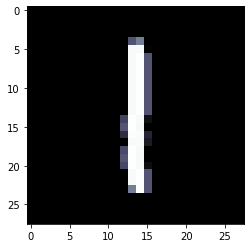

노이즈 삽입 전: (3000, 784), 노이즈 삽입 후: (3000, 784)


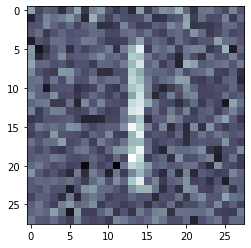

훈련 데이터
3차원 변환 후: (3000, 28, 28)
3차원 변환 후: (100, 28, 28)

테스트 데이터
3차원 변환 전: (3000, 784), 후: (3000, 28, 28)
3차원 변환 전: (100, 784), 후: (100, 28, 28)
====== 모델 전체 구조 =====
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 28, 28, 10)        0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 28, 28, 10)        910       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 1)         91        
Total params: 1,101
Trainable params: 1,101
Non-trainable params: 0
______________________

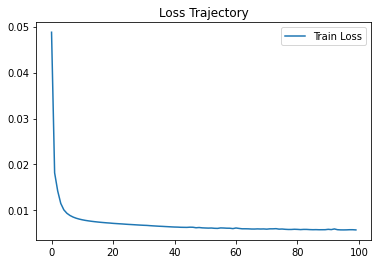

잡음이 삽입된 테스트 데이터 10개


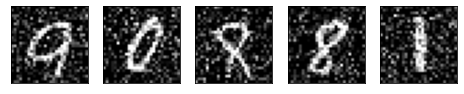

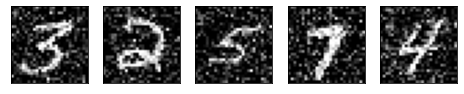

원래 테스트 데이터: (100, 28, 28)
모델에 넣기 위해 차원을 변경한 데이터: (100, 28, 28, 1)


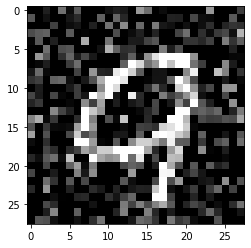

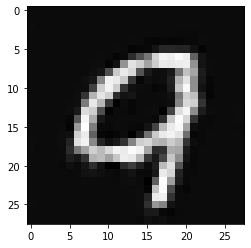

잡음을 제거한 테스트 데이터 10개


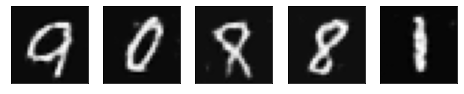

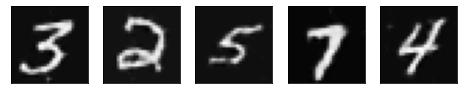

In [ ]:
# 입력 데이터 생성
X_train = mnist.data[:3000, :] / 255
X_test = mnist.data[3000:3100, :] / 255
plt.imshow(X_train[102].reshape(28, 28), cmap=plt.cm.bone)
plt.show()

# 노이즈 삽입
X_train_n = X_train + 0.3*np.random.normal(size=X_train.shape)
X_test_n = X_test + 0.3*np.random.normal(size=X_test.shape)
print(f"노이즈 삽입 전: {X_train.shape}, 노이즈 삽입 후: {X_train_n.shape}")

# 확인
plt.imshow(X_train_n[102].reshape(28, 28), cmap=plt.cm.bone)
plt.show()

# clip
X_train_n_clipped = np.clip(X_train_n, 0., 1.)
X_test_n_clipped = np.clip(X_test_n, 0., 1.)

# CNN에 주입하기 위해 차원 증가
print("훈련 데이터")
X_train = X_train.reshape(-1, 28, 28)
X_test = X_test.reshape(-1, 28, 28)
print(f"3차원 변환 후: {X_train.shape}")
print(f"3차원 변환 후: {X_test.shape}")
print("")
print("테스트 데이터")
X_train_n = X_train_n_clipped.reshape(-1, 28, 28)
X_test_n = X_test_n_clipped.reshape(-1, 28, 28)
print(f"3차원 변환 전: {X_train_n_clipped.shape}, 후: {X_train.shape}")
print(f"3차원 변환 전: {X_test_n_clipped.shape}, 후: {X_test.shape}")

# CNN 파라미터: 노이즈 데이터를 주입할 것이기 때문에 노이즈로!!
n_height = X_train_n.shape[1] # 28
n_width = X_train_n.shape[2]
n_channel = 1 # 흑백 이미지

# 오토인코더 레이어 구성
x_Input = Input(batch_shape=(None, n_height, n_width, n_channel))

# 인코더
e_conv = Conv2D(filters=10, kernel_size=(3, 3), strides=1, padding='SAME', activation='relu')(x_Input) # same: 28*28
e_pool = MaxPooling2D(pool_size=(2,2), strides=1, padding='SAME')(e_conv) # same! 28 x 28

# 디코더
d_conv = Conv2DTranspose(filters=10, kernel_size=(3, 3), strides=1, padding='SAME', activation='relu')(e_pool) # 아마 same이니까 28*28
x_Output = Conv2D(filters=1, kernel_size=(3, 3), strides=1, padding='SAME', activation='linear')(d_conv) 

# 모델 구성
model = Model(x_Input, x_Output)
model.compile(loss='mse', optimizer=Adam(lr=0.005)) # 이거 그냥 전에 sigmoid여서?
print("====== 모델 전체 구조 =====")
print(model.summary())

# 4차원에 맞추기 위해 채널 축 추가
X_train_n = X_train_n[:, :, :, np.newaxis]

# 오토인코더 학습: X_train과 X_train_n을 맞춘다.
hist = model.fit(X_train_n, X_train, epochs=100, batch_size=300, shuffle=True)

# plot loss
plt.plot(hist.history['loss'], label='Train Loss')
plt.title('Loss Trajectory')
plt.legend()
plt.show()

# 화면에 이미지 그림
def showImage(x):
    n = 0
    for k in range(2): # figure 2개에 10개 나눠 그림 그리기 위해 range(2)
        plt.figure(figsize=(8, 2))
        for i in range(5):
            ax = plt.subplot(1, 5, i+1)
            plt.imshow(x[n].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            n += 1
        plt.show()

# 노이즈가 추가된 데이터 10개
print("잡음이 삽입된 테스트 데이터 10개")
showImage(X_test_n)

# 오토인코더 모델에 통과시켜서 잡음 제거
print(f"원래 테스트 데이터: {X_test_n.shape}")
X_test_n = X_test_n.reshape(-1, 28, 28)
X_test_n = X_test_n[:, :, :, np.newaxis] # 채널 축 추가
print(f"모델에 넣기 위해 차원을 변경한 데이터: {X_test_n.shape}")

# 잡음 제거
X_test_detected = model.predict(X_test_n)
plt.imshow(X_test_n[0].reshape(28, 28))
plt.show()
plt.imshow(X_test_detected[0].reshape(28, 28))
plt.show()

# 잡음을 제거한 테스트 데이터 10개
print("잡음을 제거한 테스트 데이터 10개")
showImage(X_test_detected)

# _3_. 어떤 층이 잡음 제거하는지 보자.

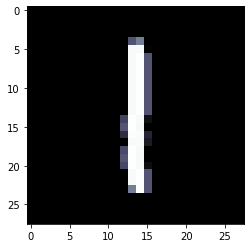

노이즈 삽입 전: (3000, 784), 노이즈 삽입 후: (3000, 784)


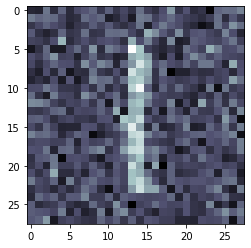

훈련 데이터
3차원 변환 후: (3000, 28, 28)
3차원 변환 후: (100, 28, 28)

테스트 데이터
3차원 변환 전: (3000, 784), 후: (3000, 28, 28)
3차원 변환 전: (100, 784), 후: (100, 28, 28)
====== 모델 전체 구조 =====
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 10)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 1)         91        
Total params: 191
Trainable params: 191
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
10/10 [==============================] - 0s 4ms/step - loss: 0.1214
Epoch 2/1

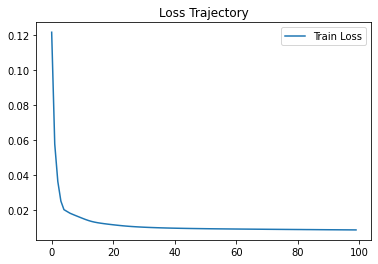

잡음이 삽입된 테스트 데이터 10개


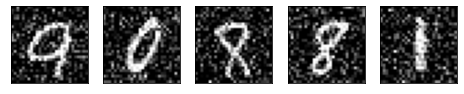

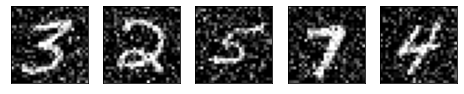

원래 테스트 데이터: (100, 28, 28)
모델에 넣기 위해 차원을 변경한 데이터: (100, 28, 28, 1)


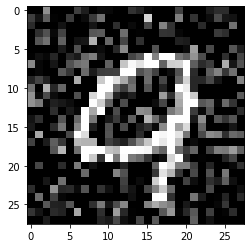

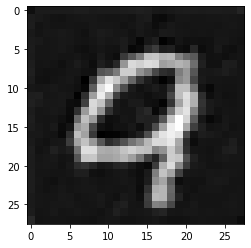

잡음을 제거한 테스트 데이터 10개


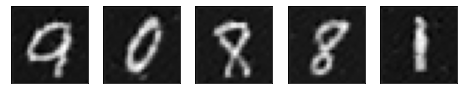

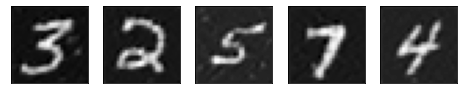

In [6]:
# 데이터 가져 오기
mnist = data

# 입력 데이터 생성
X_train = mnist.data[:3000, :] / 255
X_test = mnist.data[3000:3100, :] / 255
plt.imshow(X_train[102].reshape(28, 28), cmap=plt.cm.bone)
plt.show()

# 노이즈 삽입
X_train_n = X_train + 0.3*np.random.normal(size=X_train.shape)
X_test_n = X_test + 0.3*np.random.normal(size=X_test.shape)
print(f"노이즈 삽입 전: {X_train.shape}, 노이즈 삽입 후: {X_train_n.shape}")

# 확인
plt.imshow(X_train_n[102].reshape(28, 28), cmap=plt.cm.bone)
plt.show()

# clip
X_train_n_clipped = np.clip(X_train_n, 0., 1.)
X_test_n_clipped = np.clip(X_test_n, 0., 1.)

# CNN에 주입하기 위해 차원 증가
print("훈련 데이터")
X_train = X_train.reshape(-1, 28, 28)
X_test = X_test.reshape(-1, 28, 28)
print(f"3차원 변환 후: {X_train.shape}")
print(f"3차원 변환 후: {X_test.shape}")
print("")
print("테스트 데이터")
X_train_n = X_train_n_clipped.reshape(-1, 28, 28)
X_test_n = X_test_n_clipped.reshape(-1, 28, 28)
print(f"3차원 변환 전: {X_train_n_clipped.shape}, 후: {X_train.shape}")
print(f"3차원 변환 전: {X_test_n_clipped.shape}, 후: {X_test.shape}")

# CNN 파라미터: 노이즈 데이터를 주입할 것이기 때문에 노이즈로!!
n_height = X_train_n.shape[1] # 28
n_width = X_train_n.shape[2]
n_channel = 1 # 흑백 이미지

# 오토인코더 레이어 구성
x_Input = Input(batch_shape=(None, n_height, n_width, n_channel))

# 인코더
e_conv = Conv2D(filters=10, kernel_size=(3, 3), strides=1, padding='SAME', activation='relu')(x_Input) # same: 28*28
e_pool = MaxPooling2D(pool_size=(2,2), strides=1, padding='SAME')(e_conv) # same! 28 x 28

# 디코더
# d_conv = Conv2DTranspose(filters=10, kernel_size=(3, 3), strides=1, padding='SAME', activation='relu')(e_pool) # 아마 same이니까 28*28
x_Output = Conv2D(filters=1, kernel_size=(3, 3), strides=1, padding='SAME', activation='linear')(e_pool) 

# 모델 구성
model = Model(x_Input, x_Output)
model.compile(loss='mse', optimizer=Adam(lr=0.005)) # 이거 그냥 전에 sigmoid여서?
print("====== 모델 전체 구조 =====")
print(model.summary())

# 4차원에 맞추기 위해 채널 축 추가
X_train_n = X_train_n[:, :, :, np.newaxis]

# 오토인코더 학습: X_train과 X_train_n을 맞춘다.
hist = model.fit(X_train_n, X_train, epochs=100, batch_size=300, shuffle=True)

# plot loss
plt.plot(hist.history['loss'], label='Train Loss')
plt.title('Loss Trajectory')
plt.legend()
plt.show()

# 화면에 이미지 그림
def showImage(x):
    n = 0
    for k in range(2): # figure 2개에 10개 나눠 그림 그리기 위해 range(2)
        plt.figure(figsize=(8, 2))
        for i in range(5):
            ax = plt.subplot(1, 5, i+1)
            plt.imshow(x[n].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            n += 1
        plt.show()

# 노이즈가 추가된 데이터 10개
print("잡음이 삽입된 테스트 데이터 10개")
showImage(X_test_n)

# 오토인코더 모델에 통과시켜서 잡음 제거
print(f"원래 테스트 데이터: {X_test_n.shape}")
X_test_n = X_test_n.reshape(-1, 28, 28)
X_test_n = X_test_n[:, :, :, np.newaxis] # 채널 축 추가
print(f"모델에 넣기 위해 차원을 변경한 데이터: {X_test_n.shape}")

# 잡음 제거
X_test_detected = model.predict(X_test_n)
plt.imshow(X_test_n[0].reshape(28, 28))
plt.show()
plt.imshow(X_test_detected[0].reshape(28, 28))
plt.show()

# 잡음을 제거한 테스트 데이터 10개
print("잡음을 제거한 테스트 데이터 10개")
showImage(X_test_detected)

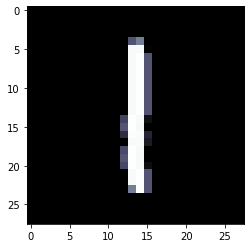

노이즈 삽입 전: (3000, 784), 노이즈 삽입 후: (3000, 784)


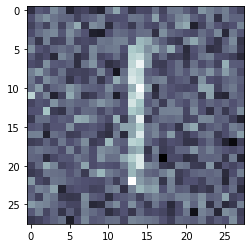

훈련 데이터
3차원 변환 후: (3000, 28, 28)
3차원 변환 후: (100, 28, 28)

테스트 데이터
3차원 변환 전: (3000, 784), 후: (3000, 28, 28)
3차원 변환 전: (100, 784), 후: (100, 28, 28)
====== 모델 전체 구조 =====
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 10)        100       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 1)         91        
Total params: 191
Trainable params: 191
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0618
Epoch 2/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0280
Epoch 3/100
10/10 [==============================] - 0s 3ms

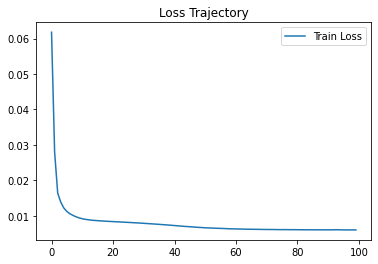

잡음이 삽입된 테스트 데이터 10개


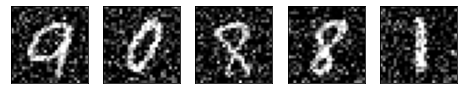

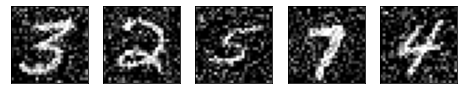

원래 테스트 데이터: (100, 28, 28)
모델에 넣기 위해 차원을 변경한 데이터: (100, 28, 28, 1)


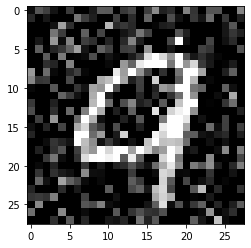

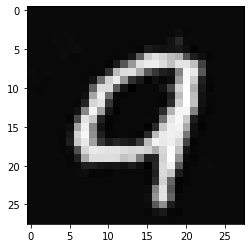

잡음을 제거한 테스트 데이터 10개


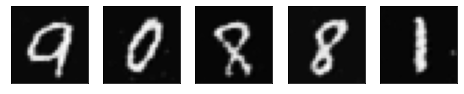

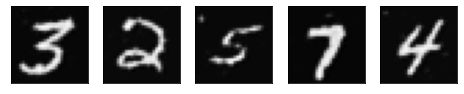

In [7]:
# 데이터 가져 오기
mnist = data

# 입력 데이터 생성
X_train = mnist.data[:3000, :] / 255
X_test = mnist.data[3000:3100, :] / 255
plt.imshow(X_train[102].reshape(28, 28), cmap=plt.cm.bone)
plt.show()

# 노이즈 삽입
X_train_n = X_train + 0.3*np.random.normal(size=X_train.shape)
X_test_n = X_test + 0.3*np.random.normal(size=X_test.shape)
print(f"노이즈 삽입 전: {X_train.shape}, 노이즈 삽입 후: {X_train_n.shape}")

# 확인
plt.imshow(X_train_n[102].reshape(28, 28), cmap=plt.cm.bone)
plt.show()

# clip
X_train_n_clipped = np.clip(X_train_n, 0., 1.)
X_test_n_clipped = np.clip(X_test_n, 0., 1.)

# CNN에 주입하기 위해 차원 증가
print("훈련 데이터")
X_train = X_train.reshape(-1, 28, 28)
X_test = X_test.reshape(-1, 28, 28)
print(f"3차원 변환 후: {X_train.shape}")
print(f"3차원 변환 후: {X_test.shape}")
print("")
print("테스트 데이터")
X_train_n = X_train_n_clipped.reshape(-1, 28, 28)
X_test_n = X_test_n_clipped.reshape(-1, 28, 28)
print(f"3차원 변환 전: {X_train_n_clipped.shape}, 후: {X_train.shape}")
print(f"3차원 변환 전: {X_test_n_clipped.shape}, 후: {X_test.shape}")

# CNN 파라미터: 노이즈 데이터를 주입할 것이기 때문에 노이즈로!!
n_height = X_train_n.shape[1] # 28
n_width = X_train_n.shape[2]
n_channel = 1 # 흑백 이미지

# 오토인코더 레이어 구성
x_Input = Input(batch_shape=(None, n_height, n_width, n_channel))

# 인코더
e_conv = Conv2D(filters=10, kernel_size=(3, 3), strides=1, padding='SAME', activation='relu')(x_Input) # same: 28*28
# e_pool = MaxPooling2D(pool_size=(2,2), strides=1, padding='SAME')(e_conv) # same! 28 x 28

# 디코더
# d_conv = Conv2DTranspose(filters=10, kernel_size=(3, 3), strides=1, padding='SAME', activation='relu')(e_pool) # 아마 same이니까 28*28
x_Output = Conv2D(filters=1, kernel_size=(3, 3), strides=1, padding='SAME', activation='linear')(e_conv) 

# 모델 구성
model = Model(x_Input, x_Output)
model.compile(loss='mse', optimizer=Adam(lr=0.005)) # 이거 그냥 전에 sigmoid여서?
print("====== 모델 전체 구조 =====")
print(model.summary())

# 4차원에 맞추기 위해 채널 축 추가
X_train_n = X_train_n[:, :, :, np.newaxis]

# 오토인코더 학습: X_train과 X_train_n을 맞춘다.
hist = model.fit(X_train_n, X_train, epochs=100, batch_size=300, shuffle=True)

# plot loss
plt.plot(hist.history['loss'], label='Train Loss')
plt.title('Loss Trajectory')
plt.legend()
plt.show()

# 화면에 이미지 그림
def showImage(x):
    n = 0
    for k in range(2): # figure 2개에 10개 나눠 그림 그리기 위해 range(2)
        plt.figure(figsize=(8, 2))
        for i in range(5):
            ax = plt.subplot(1, 5, i+1)
            plt.imshow(x[n].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            n += 1
        plt.show()

# 노이즈가 추가된 데이터 10개
print("잡음이 삽입된 테스트 데이터 10개")
showImage(X_test_n)

# 오토인코더 모델에 통과시켜서 잡음 제거
print(f"원래 테스트 데이터: {X_test_n.shape}")
X_test_n = X_test_n.reshape(-1, 28, 28)
X_test_n = X_test_n[:, :, :, np.newaxis] # 채널 축 추가
print(f"모델에 넣기 위해 차원을 변경한 데이터: {X_test_n.shape}")

# 잡음 제거
X_test_detected = model.predict(X_test_n)
plt.imshow(X_test_n[0].reshape(28, 28))
plt.show()
plt.imshow(X_test_detected[0].reshape(28, 28))
plt.show()

# 잡음을 제거한 테스트 데이터 10개
print("잡음을 제거한 테스트 데이터 10개")
showImage(X_test_detected)

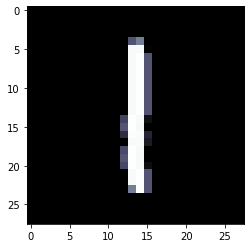

노이즈 삽입 전: (3000, 784), 노이즈 삽입 후: (3000, 784)


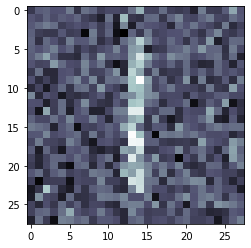

훈련 데이터
3차원 변환 후: (3000, 28, 28)
3차원 변환 후: (100, 28, 28)

테스트 데이터
3차원 변환 전: (3000, 784), 후: (3000, 28, 28)
3차원 변환 전: (100, 784), 후: (100, 28, 28)
====== 모델 전체 구조 =====
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 1)         10        
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 0.3066
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 0.1872
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 0.1266
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 0.1029
Epoch 5/100
10/10 [==============

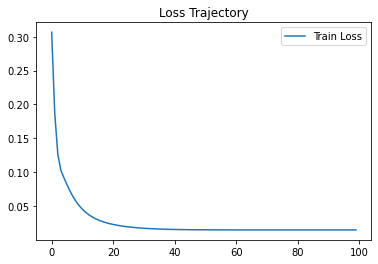

잡음이 삽입된 테스트 데이터 10개


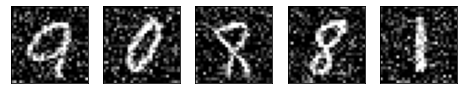

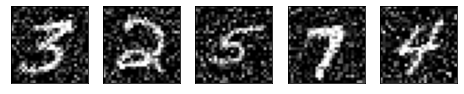

원래 테스트 데이터: (100, 28, 28)
모델에 넣기 위해 차원을 변경한 데이터: (100, 28, 28, 1)


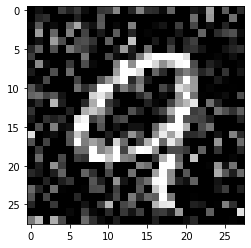

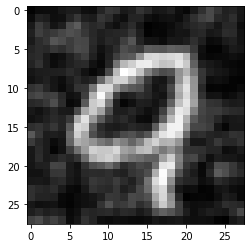

잡음을 제거한 테스트 데이터 10개


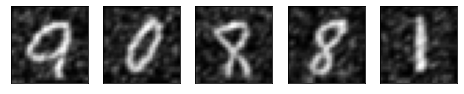

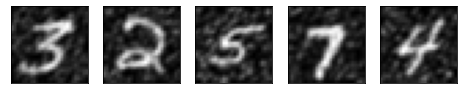

In [8]:
# 데이터 가져 오기
mnist = data

# 입력 데이터 생성
X_train = mnist.data[:3000, :] / 255
X_test = mnist.data[3000:3100, :] / 255
plt.imshow(X_train[102].reshape(28, 28), cmap=plt.cm.bone)
plt.show()

# 노이즈 삽입
X_train_n = X_train + 0.3*np.random.normal(size=X_train.shape)
X_test_n = X_test + 0.3*np.random.normal(size=X_test.shape)
print(f"노이즈 삽입 전: {X_train.shape}, 노이즈 삽입 후: {X_train_n.shape}")

# 확인
plt.imshow(X_train_n[102].reshape(28, 28), cmap=plt.cm.bone)
plt.show()

# clip
X_train_n_clipped = np.clip(X_train_n, 0., 1.)
X_test_n_clipped = np.clip(X_test_n, 0., 1.)

# CNN에 주입하기 위해 차원 증가
print("훈련 데이터")
X_train = X_train.reshape(-1, 28, 28)
X_test = X_test.reshape(-1, 28, 28)
print(f"3차원 변환 후: {X_train.shape}")
print(f"3차원 변환 후: {X_test.shape}")
print("")
print("테스트 데이터")
X_train_n = X_train_n_clipped.reshape(-1, 28, 28)
X_test_n = X_test_n_clipped.reshape(-1, 28, 28)
print(f"3차원 변환 전: {X_train_n_clipped.shape}, 후: {X_train.shape}")
print(f"3차원 변환 전: {X_test_n_clipped.shape}, 후: {X_test.shape}")

# CNN 파라미터: 노이즈 데이터를 주입할 것이기 때문에 노이즈로!!
n_height = X_train_n.shape[1] # 28
n_width = X_train_n.shape[2]
n_channel = 1 # 흑백 이미지

# 오토인코더 레이어 구성
x_Input = Input(batch_shape=(None, n_height, n_width, n_channel))

# 인코더
# e_conv = Conv2D(filters=10, kernel_size=(3, 3), strides=1, padding='SAME', activation='relu')(x_Input) # same: 28*28
# e_pool = MaxPooling2D(pool_size=(2,2), strides=1, padding='SAME')(e_conv) # same! 28 x 28

# 디코더
# d_conv = Conv2DTranspose(filters=10, kernel_size=(3, 3), strides=1, padding='SAME', activation='relu')(e_pool) # 아마 same이니까 28*28
x_Output = Conv2D(filters=1, kernel_size=(3, 3), strides=1, padding='SAME', activation='linear')(x_Input) 

# 모델 구성
model = Model(x_Input, x_Output)
model.compile(loss='mse', optimizer=Adam(lr=0.005)) # 이거 그냥 전에 sigmoid여서?
print("====== 모델 전체 구조 =====")
print(model.summary())

# 4차원에 맞추기 위해 채널 축 추가
X_train_n = X_train_n[:, :, :, np.newaxis]

# 오토인코더 학습: X_train과 X_train_n을 맞춘다.
hist = model.fit(X_train_n, X_train, epochs=100, batch_size=300, shuffle=True)

# plot loss
plt.plot(hist.history['loss'], label='Train Loss')
plt.title('Loss Trajectory')
plt.legend()
plt.show()

# 화면에 이미지 그림
def showImage(x):
    n = 0
    for k in range(2): # figure 2개에 10개 나눠 그림 그리기 위해 range(2)
        plt.figure(figsize=(8, 2))
        for i in range(5):
            ax = plt.subplot(1, 5, i+1)
            plt.imshow(x[n].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            n += 1
        plt.show()

# 노이즈가 추가된 데이터 10개
print("잡음이 삽입된 테스트 데이터 10개")
showImage(X_test_n)

# 오토인코더 모델에 통과시켜서 잡음 제거
print(f"원래 테스트 데이터: {X_test_n.shape}")
X_test_n = X_test_n.reshape(-1, 28, 28)
X_test_n = X_test_n[:, :, :, np.newaxis] # 채널 축 추가
print(f"모델에 넣기 위해 차원을 변경한 데이터: {X_test_n.shape}")

# 잡음 제거
X_test_detected = model.predict(X_test_n)
plt.imshow(X_test_n[0].reshape(28, 28))
plt.show()
plt.imshow(X_test_detected[0].reshape(28, 28))
plt.show()

# 잡음을 제거한 테스트 데이터 10개
print("잡음을 제거한 테스트 데이터 10개")
showImage(X_test_detected)